In [1]:
suppressPackageStartupMessages({

    library(VariantAnnotation)
    library(tidyverse)
    library(magrittr)
    library(here)
    library(bdkn)
    library(rtracklayer)
    library(phangorn)

})

In [2]:
source(here("src/utils.R"))

In [3]:
vcf <- read_gt(here("data/vcf/merged_full.vcf.gz"), var_only = TRUE)

In [4]:
pops <- tibble(
    name = c(str_subset(colnames(vcf), "^S_"), "a00"),
    pop = case_when(
        name %in% c("S_Burmese_1", "S_Thai_1", "S_Han_2", "S_Dai_2", "S_Punjabi_1", "S_Papuan_2", "S_Karitiana_1") ~ "EastEur",
        name %in% c("S_BedouinB_1", "S_Turkish_1", "S_French_1", "S_Finnish_2", "S_Sardinian_1", "S_Saami_2") ~ "WestEur",
        TRUE ~ "Africa"
    )
)

In [5]:
gt <- select(vcf, -c(chrom, pos, REF, ALT, reference, a00_1, a00_2, denisova8sub))

In [6]:
counts <- select(gt, -chimp) %>% rowSums(na.rm = TRUE)

Keep only variable sites (excluding variable only in chimp):

In [7]:
gt <- filter(gt, counts > 0 & counts < (ncol(vcf) - 1))

In [8]:
derived <- mutate_all(gt, ~ as.integer(.x != gt$chimp))

In [10]:
derived %>% filter(a00 == 1) %>% head

chimp,spy1,mez2,comb_neand,denisova8,S_BedouinB_1,S_Turkish_1,S_French_1,S_Burmese_1,S_Thai_1,⋯,S_Yoruba_2,S_Gambian_1,S_Mandenka_1,S_Ju_hoan_North_1,ustishim,a00,kk1,mota,bichon,loschbour
0,NA,NA,NA,NA,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,NA,0
0,NA,NA,NA,0,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,NA,1
0,NA,1,1,0,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,NA,1
0,NA,NA,NA,NA,0,0,0,0,0,⋯,0,0,0,0,NA,1,0,0,NA,0
0,NA,NA,NA,0,1,1,1,1,1,⋯,1,1,1,1,1,1,NA,1,1,1
0,NA,NA,NA,NA,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,NA,0


In [129]:
aln <- read.phyDat(here("data/fasta/modern_full.fa"), format = "fasta")

In [154]:
tree <- NJ(dist.ml(aln))
tree$tip.label <- str_replace(tree$tip.label, "-", "_")

In [155]:
rooted_tree <- root(tree, outgroup = c("chimp"), resolve.root = TRUE)

# Fixed African ancestral vs fixed derived non-African sites

In [520]:
(outgroup <- filter(pops, pop == "Africa")$name)
(ingroup <- filter(pops, pop != "Africa")$name)

[1] "S_Dinka_1"         "S_Mbuti_1"         "S_Yoruba_2"       
[4] "S_Gambian_1"       "S_Mandenka_1"      "S_Ju_hoan_North_1"
[7] "a00"

[1] "S_BedouinB_1"  "S_Turkish_1"   "S_French_1"    "S_Burmese_1"  
 [5] "S_Thai_1"      "S_Finnish_2"   "S_Sardinian_1" "S_Han_2"      
 [9] "S_Dai_2"       "S_Punjabi_1"   "S_Saami_2"     "S_Papuan_2"   
[13] "S_Karitiana_1"

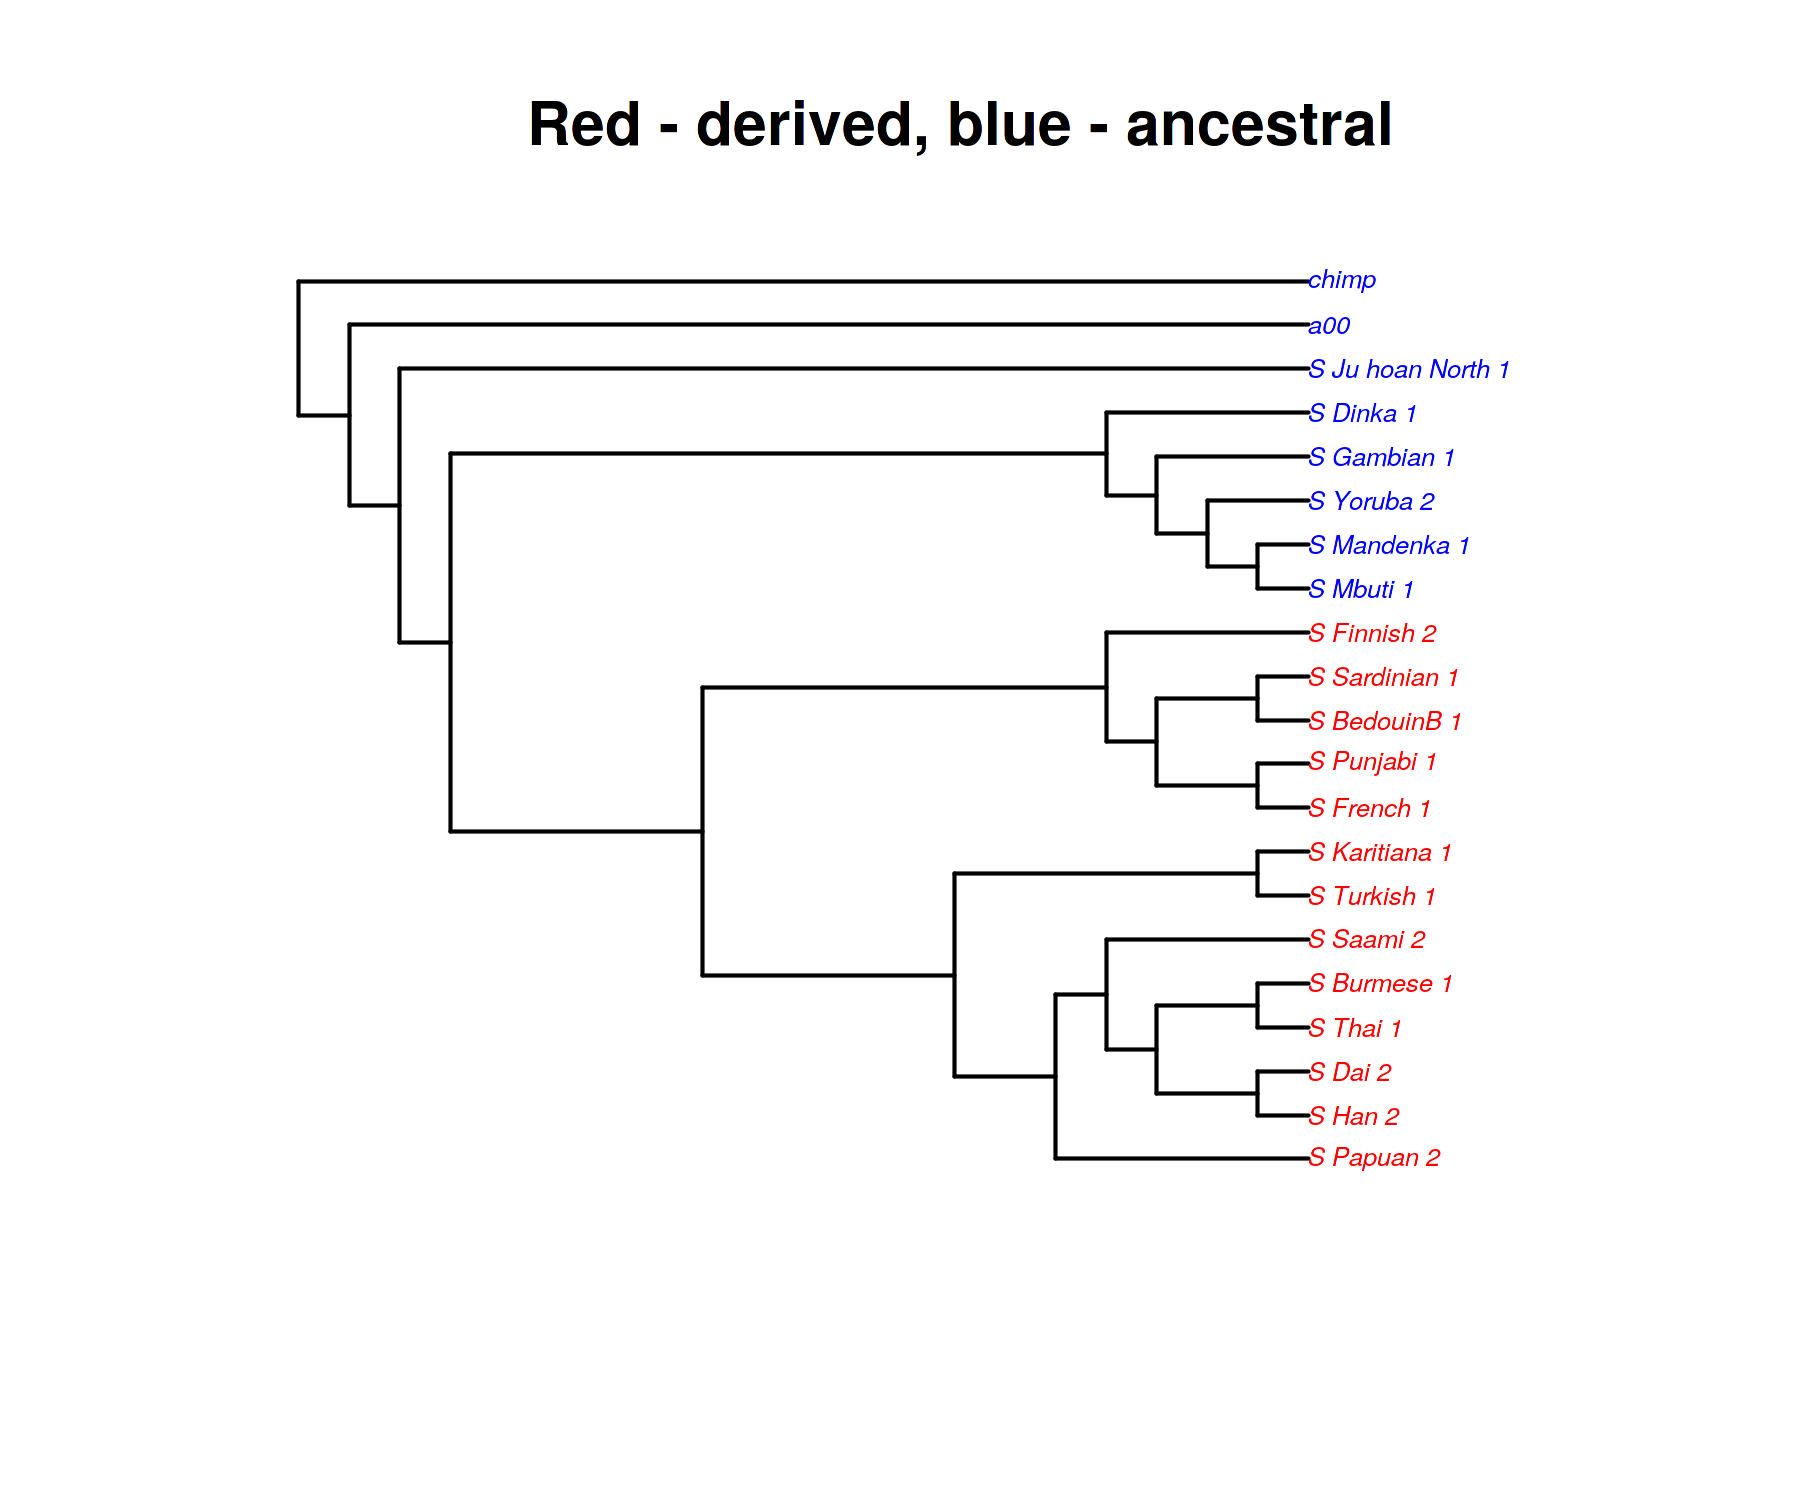

In [521]:
set_dim(6, 5, 300)

cols <- map_chr(rooted_tree$tip.label, ~ ifelse(.x %in% ingroup, "red", "blue"))

plot(rooted_tree, use.edge.length = FALSE, tip.color = cols, cex = 0.5)
title("Red - derived, blue - ancestral")

In [522]:
out_anc <- (rowMeans(derived[, outgroup]) == 0)
in_der <- (rowMeans(derived[, ingroup]) >= 1)

In [523]:
fixed <- derived[out_anc & in_der, ] %>% select(-one_of(c(outgroup, ingroup)))

Proportion of sites in an aDNA sample carrying the derived allele shared with the <font color="red">red individuals</font>:

In [524]:
fixed %>% summarise_all(mean, na.rm = TRUE)

chimp,spy1,mez2,comb_neand,denisova8,ustishim,kk1,mota,bichon,loschbour
0,0,0,0,0,1,1,0.02083333,1,1


Total number of such informative sites:

In [525]:
fixed %>% summarise_all(~sum(!is.na(.x)))

chimp,spy1,mez2,comb_neand,denisova8,ustishim,kk1,mota,bichon,loschbour
76,1,4,10,16,70,60,48,39,70


# Fixed A00&San ancestral vs fixed derived other sites

In [526]:
outgroup <- c("a00", "S_Ju_hoan_North_1")
(ingroup <- filter(pops, !name %in% outgroup)$name)

[1] "S_BedouinB_1"  "S_Turkish_1"   "S_French_1"    "S_Burmese_1"  
 [5] "S_Thai_1"      "S_Finnish_2"   "S_Sardinian_1" "S_Han_2"      
 [9] "S_Dai_2"       "S_Punjabi_1"   "S_Saami_2"     "S_Papuan_2"   
[13] "S_Karitiana_1" "S_Dinka_1"     "S_Mbuti_1"     "S_Yoruba_2"   
[17] "S_Gambian_1"   "S_Mandenka_1"

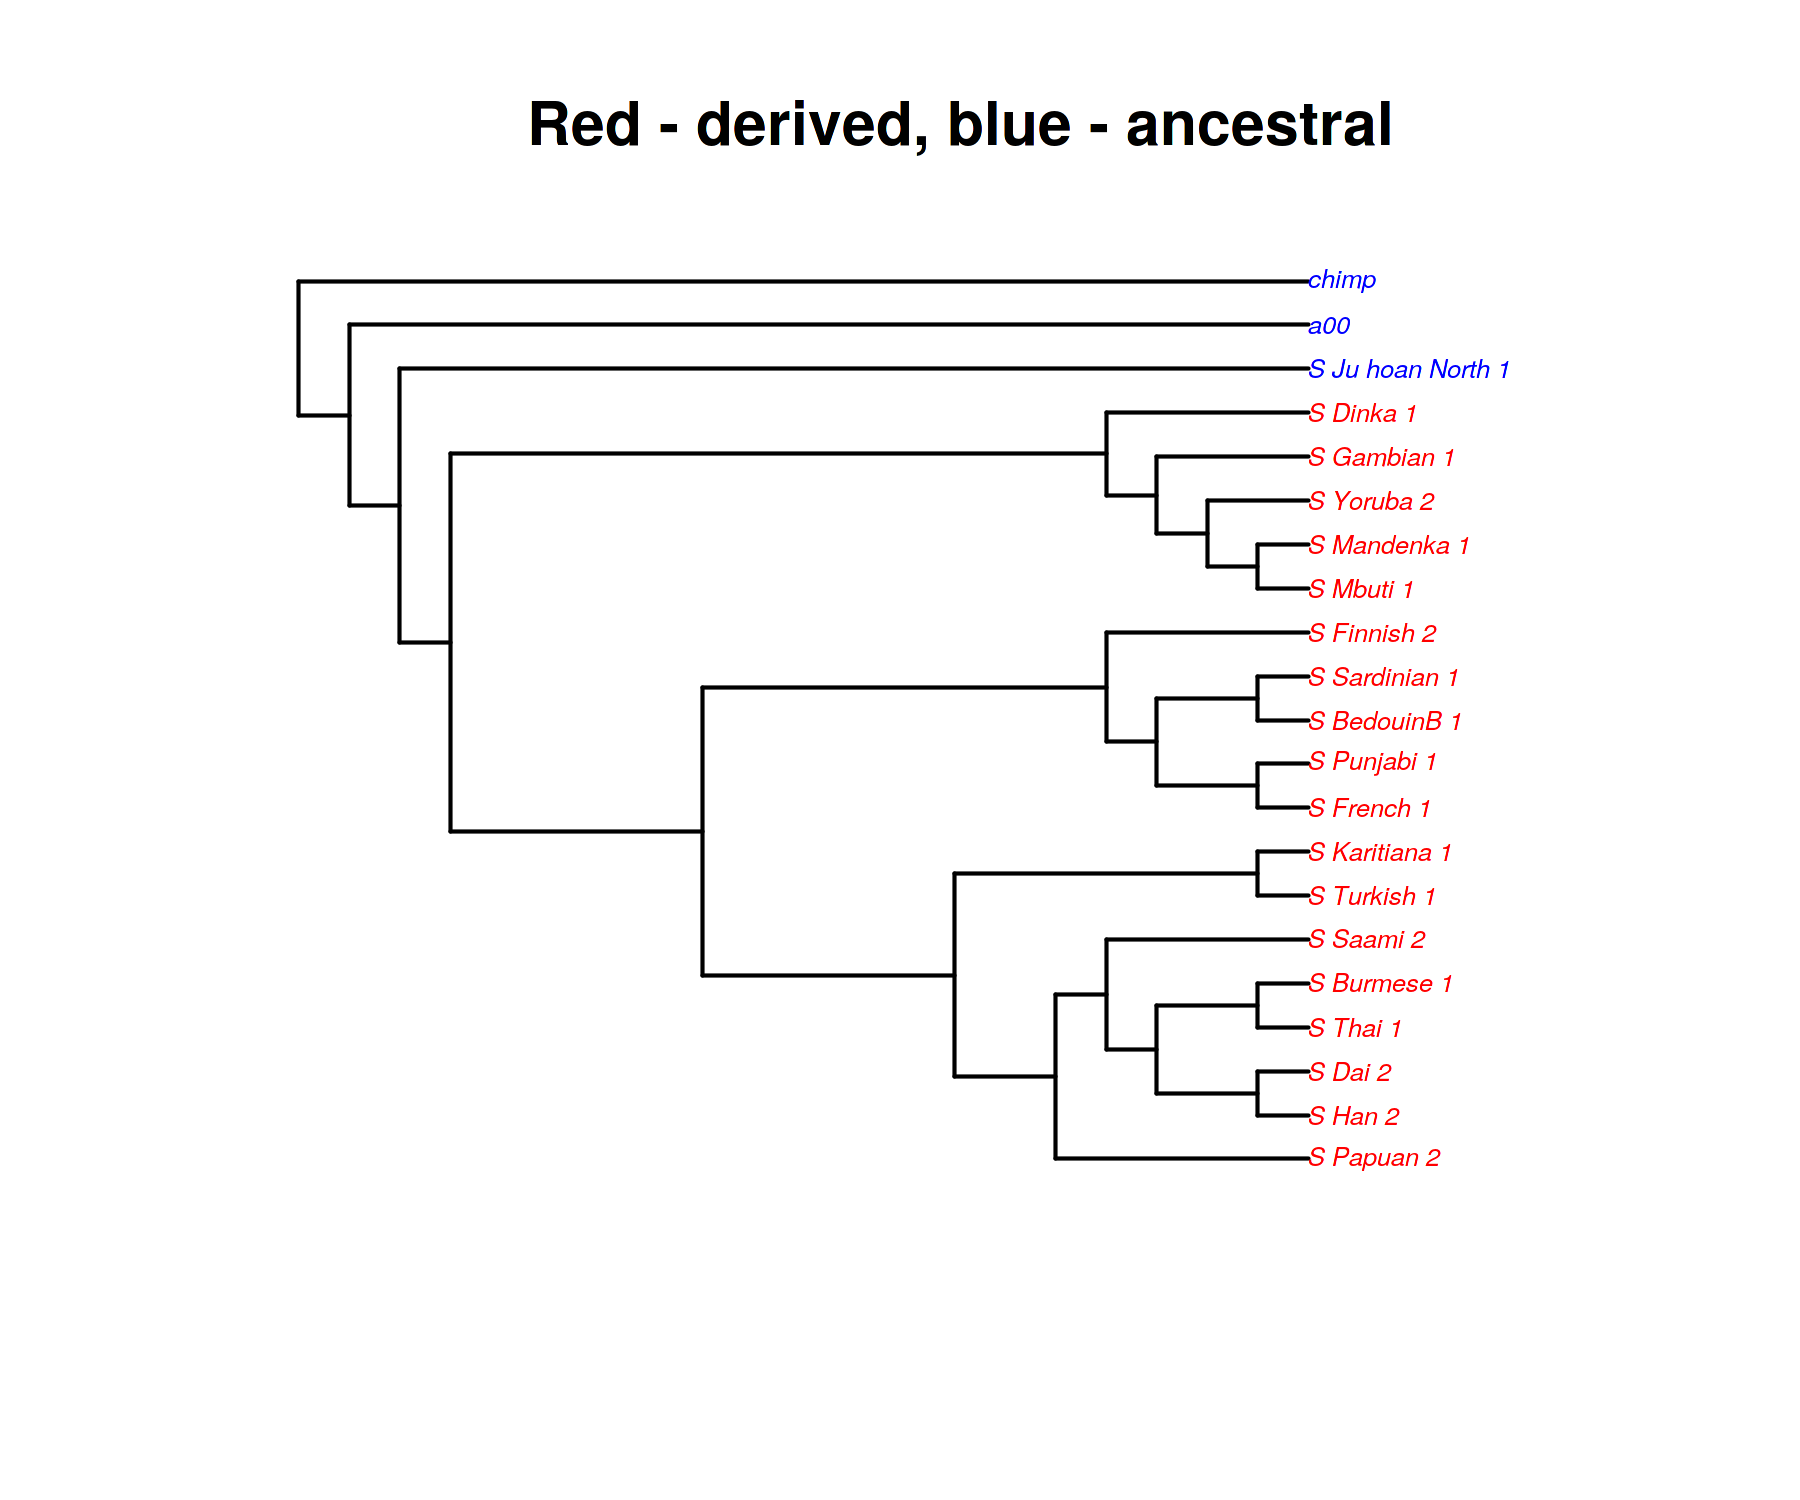

In [527]:
set_dim(6, 5, 300)

cols <- map_chr(rooted_tree$tip.label, ~ ifelse(.x %in% ingroup, "red", "blue"))

plot(rooted_tree, use.edge.length = FALSE, tip.color = cols, cex = 0.5)
title("Red - derived, blue - ancestral")

In [528]:
out_anc <- (rowSums(derived[, outgroup]) == 0)
in_der <- (rowSums(derived[, ingroup]) == length(ingroup))

In [529]:
fixed <- derived[out_anc & in_der, ] %>% select(-one_of(pops$name))

Proportion of sites in an aDNA sample carrying the derived allele shared with the <font color="red">red individuals</font>:

In [530]:
fixed %>% summarise_all(mean, na.rm = TRUE)

chimp,spy1,mez2,comb_neand,denisova8,ustishim,kk1,mota,bichon,loschbour
0,0,0,0,0,1,1,1,1,1


Total number of such informative sites:

In [531]:
fixed %>% summarise_all(~sum(!is.na(.x)))

chimp,spy1,mez2,comb_neand,denisova8,ustishim,kk1,mota,bichon,loschbour
121,1,7,12,30,117,90,102,67,115
